<a href="https://colab.research.google.com/github/slunara/car_damage_detector/blob/main/models/EfficientNetV2S_additional_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car damage classifier

EfficientNetV2S pre trained model is used to classify where the image contain the damaged car or not.

In [1]:
#import necessary librabry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Download data


In [2]:
import kagglehub
import shutil
import os

# Step 1: Download dataset (it will go to /root/.cache/... by default)
dataset_path = kagglehub.dataset_download("anujms/car-damage-detection")
print("Dataset downloaded to:", dataset_path)

# Step 2: Define custom target location
custom_path = "/content/dataset"  # Change this to your desired location

# Step 3: Move dataset from default location to custom location
if os.path.exists(dataset_path):
    shutil.move(dataset_path, custom_path)
    print(f"✅ Dataset successfully moved to {custom_path}")
else:
    print("⚠️ Dataset download failed or path does not exist.")

100%|██████████| 123M/123M [00:06<00:00, 19.6MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1
✅ Dataset successfully moved to /content/dataset


In [3]:
dataset_path = "/content/dataset/data1a"
os.listdir(dataset_path)

['validation', 'training']

In [5]:
train_dir = os.path.join(dataset_path, 'training')
validation_dir = os.path.join(dataset_path, 'validation')

In [6]:
#defining the damage and whole , train and validation directory
train_damage_dir = os.path.join(train_dir, '00-damage')
train_whole_dir = os.path.join(train_dir, '01-whole')
validation_damage_dir = os.path.join(validation_dir, '00-damage')
validation_whole_dir = os.path.join(validation_dir, '01-whole')

In [7]:
def count_images(directory):
    return len([img for img in os.listdir(directory) if os.path.isfile(os.path.join(directory, img))])

# Count images in both categories
num_damage = count_images(train_damage_dir)
num_whole = count_images(train_whole_dir)

print(f"✅ Number of images in 00-damage: {num_damage}")
print(f"✅ Number of images in 01-whole: {num_whole}")

✅ Number of images in 00-damage: 920
✅ Number of images in 01-whole: 920


In [8]:
!rm -rf /content/TQVCD_dataset  # Remove old repo if it exists
!git clone https://github.com/dxlabskku/TQVCD /content/TQVCD_dataset

Cloning into '/content/TQVCD_dataset'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 272 (delta 30), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (272/272), 21.01 MiB | 15.61 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [9]:
import os

folder_path = "/content/TQVCD_dataset/RC"  # Adjust if needed

# List everything inside the folder
contents = os.listdir(folder_path)

print(f"📂 Contents of {folder_path}:")
print(contents)


📂 Contents of /content/TQVCD_dataset/RC:
['RC_8.jpg', 'RC_11.jpg', 'RC_5.jpg', 'RC_17.jpg', 'RC_7.jpg', 'RC_20.jpg', 'RC_2.jpg', 'RC_10.jpg', 'RC_19.jpg', 'RC_15.jpg', 'RC_18.jpg', 'RC_4.jpg', 'RC_14.jpg', 'RC_6.jpg', 'RC_9.jpg', 'RC_13.jpg', 'RC_16.jpg', 'RC_3.jpg', 'RC_1.jpg', 'RC_12.jpg']


In [10]:
github_dataset_path = "/content/TQVCD_dataset"

# Define GitHub dataset folder mappings
github_source_folders = {
    "whole": ["FN", "RN"],  # Undamaged cars → move to train_whole_dir
    "damage": ["FB", "FC", "RB", "RC"]  # Damaged cars → move to train_damage_dir
}

In [11]:
# Move images from GitHub dataset to Kaggle dataset directories
def move_all_images(src_root, target_dir):
    for root, _, files in os.walk(src_root):  # Recursively go through subfolders
        for img_name in files:
            img_src = os.path.join(root, img_name)
            img_dst = os.path.join(target_dir, img_name)

            # Prevent overwriting by renaming duplicate images
            if os.path.exists(img_dst):
                base, ext = os.path.splitext(img_name)
                img_dst = os.path.join(target_dir, f"github_{base}{ext}")

            shutil.move(img_src, img_dst)

# Move "whole" (undamaged) images
for folder in ["FN", "RN"]:  # Adjust based on GitHub folder names
    src_path = os.path.join(github_dataset_path, folder)
    if os.path.exists(src_path):
        move_all_images(src_path, train_whole_dir)

# Move "damage" (damaged) images
for folder in ["FB", "FC", "RB", "RC"]:  # Adjust based on GitHub folder names
    src_path = os.path.join(github_dataset_path, folder)
    if os.path.exists(src_path):
        move_all_images(src_path, train_damage_dir)

print("✅ All GitHub dataset images (including subfolders) moved successfully!")


✅ All GitHub dataset images (including subfolders) moved successfully!


In [12]:
# Function to count images in a directory
def count_images(directory):
    return len([img for img in os.listdir(directory) if os.path.isfile(os.path.join(directory, img))])

# Count images in both categories
num_damage = count_images(train_damage_dir)
num_whole = count_images(train_whole_dir)

print(f"✅ Number of images in 00-damage: {num_damage}")
print(f"✅ Number of images in 01-whole: {num_whole}")


✅ Number of images in 00-damage: 1000
✅ Number of images in 01-whole: 960


## Preprocess the data

Data Augmentation is used to:
1. Rescale the data
2. to bring all the image to same dimension  i.e. 150x150


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1960 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


## Fine tune EfficientNetV2S

For training 1840 images are used.
For Validation 460 image are used.

Training and evaluating the model with binary crossentropy loss, accuracy, precision , recall.

In [15]:
# Import necessary modules
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetV2S  # EfficientNetV2 Small
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from itertools import product

# Define hyperparameter grid
LEARNING_RATES = [1e-4]
BATCH_SIZES = [16]
DROPOUT_RATES = [0.3]
OPTIMIZERS = ["rmsprop"]

best_model = None
best_val_acc = 0
best_hyperparams = None

# Grid Search over hyperparameter combinations
for lr, bs, dropout, opt in product(LEARNING_RATES, BATCH_SIZES, DROPOUT_RATES, OPTIMIZERS):
    print(f"\n🔍 Training with: LR={lr}, Batch Size={bs}, Dropout={dropout}, Optimizer={opt}")

    # Load EfficientNetV2 base model (without top layers)
    base_model = EfficientNetV2S(input_shape=(150, 150, 3), include_top=False, weights="imagenet")
    base_model.trainable = False  # Freeze early layers for transfer learning

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(dropout)(x)  # Tunable dropout rate
    x = Dense(1, activation="sigmoid")(x)  # Binary classification

    # Define final model
    model = Model(base_model.input, x)

    # Choose optimizer
    if opt == "adam":
        optimizer = Adam(learning_rate=lr)
    elif opt == "rmsprop":
        optimizer = RMSprop(learning_rate=lr)

    # Compile model
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy", "Precision", "Recall"])


    # Train the model
    history = model.fit(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        verbose=2
    )

    # Get best validation accuracy
    val_acc = max(history.history["val_accuracy"])

    # Track the best performing model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_hyperparams = (lr, bs, dropout, opt)
        best_model = model

print(f"\n🔥 Best Hyperparameters: LR={best_hyperparams[0]}, Batch Size={best_hyperparams[1]}, Dropout={best_hyperparams[2]}, Optimizer={best_hyperparams[3]}")


🔍 Training with: LR=0.0001, Batch Size=16, Dropout=0.3, Optimizer=rmsprop
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 - 67s - 683ms/step - Precision: 0.5587 - Recall: 0.5354 - accuracy: 0.5653 - loss: 0.6811 - val_Precision: 0.6901 - val_Recall: 0.5130 - val_accuracy: 0.6413 - val_loss: 0.6514
Epoch 2/200
98/98 - 6s - 66ms/step - Precision: 0.5948 - Recall: 0.5948 - accuracy: 0.6031 - loss: 0.6551 - val_Precision: 0.6263 - val_Recall: 0.8087 - val_accuracy: 0.6630 - val_loss: 0.6409
Epoch 3/200
98/98 - 7s - 73ms/step - Precision: 0.6337 - Recall: 0.6469 - accuracy: 0.6439 - loss: 0.6406 - val_Precision: 0.7383 - val_Recall: 0.4783 - val_accuracy: 0.6543 - val_loss: 0.6296
Epoch 4/200
98/98 - 7s - 68ms/step - Precision: 0.6251 - Recall: 0.6323 - accuracy: 0.6342 - loss: 0.6361 - val_Precision: 0.6950 - val_Recall: 0.6043 - val_accuracy: 0.6696 - val_loss: 0.6176
Epoch 5/200
98/98 - 10s - 103ms/step - Precision: 0.6465 - Recall: 0.6344 - accuracy: 0.6510 - loss: 0.6290 - val_Precision: 0.6681 - val_Recall: 0.6826 - val_accuracy: 0.6717 - val_loss: 0.6125
Epoch 6/200
98/98 - 7s - 75ms/step - Precis

In [16]:
model=best_model
#weights saving
model.save("classifier.keras")

## TensorFlow Lite Model -- app deployment

Save the best model as TensorFlow Lite Model to deploy it as an app.

In [17]:
train_generator.class_indices

{'00-damage': 0, '01-whole': 1}

In [18]:
if best_model:
    converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
    tflite_model = converter.convert()

    with open("best_model.tflite", "wb") as f:
        f.write(tflite_model)

    print("✅ Best model successfully converted to TensorFlow Lite format!")

    labels = "\n".join(train_generator.class_indices.keys())  # Fix variable reference
    with open("labels.txt", "w") as f:
        f.write(labels)

    print("✅ Labels saved to labels.txt")
else:
    print("⚠️ No best model found! Ensure training completed successfully.")

Saved artifact at '/tmp/tmpchphxyoq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134877522638416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134877522638800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134877522640144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134877522636688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134877522637840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134877522635344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134877522635536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134877522637072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134877519861456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134877522639760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13487571802177

In [19]:
from google.colab import files

files.download("best_model.tflite")
files.download("labels.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Results

plotting the history of train and validation loss, accurcy, precision, recall

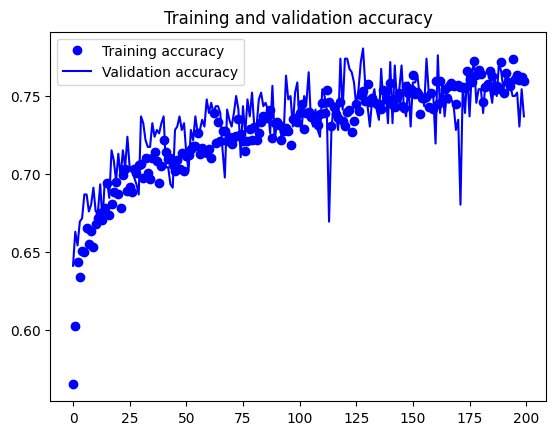

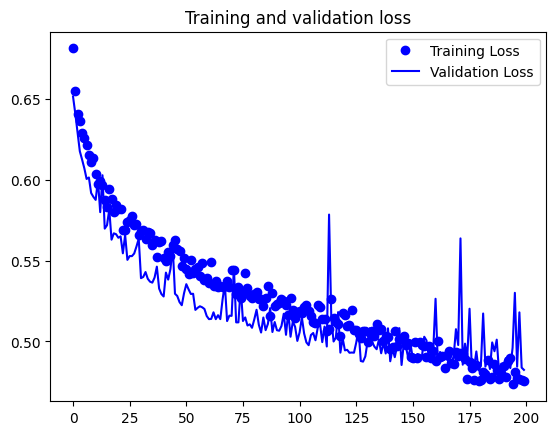

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

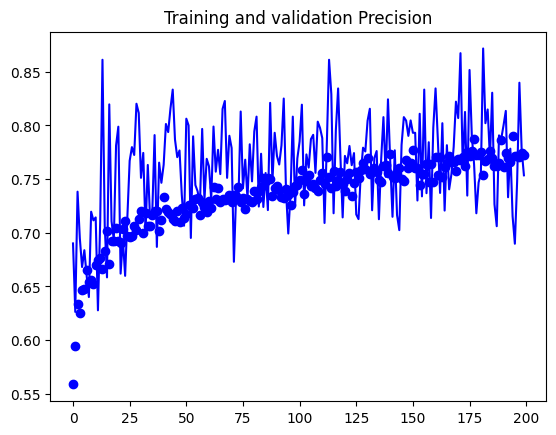

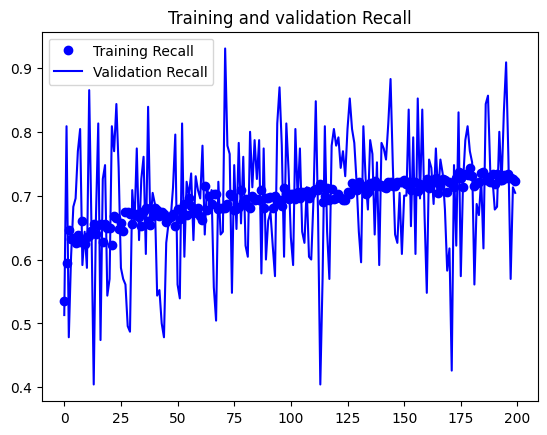

In [21]:

acc = history.history['Precision']
val_acc = history.history['val_Precision']
loss = history.history['Recall']
val_loss = history.history['val_Recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Precision')
plt.plot(epochs, val_acc, 'b', label='Validation Precision')
plt.title('Training and validation Precision')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Recall')
plt.plot(epochs, val_loss, 'b', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.show()

Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
The car is damaged


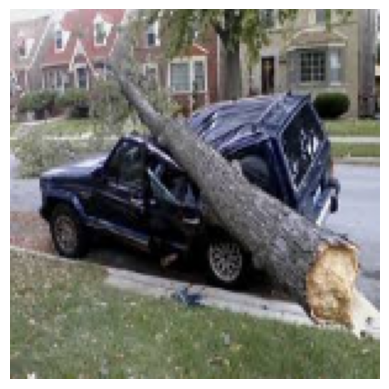

In [23]:
import cv2
im = cv2.imread("/content/dataset/data1a/validation/00-damage/0001.JPEG")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (150, 150))
imS=im.reshape([1,150,150,3])
pred=model.predict(np.array(imS))
if pred[0][0]<0.5:
    print("The car is damaged")
else:
    print("The car is not damaged")
plt.axis("off")
plt.imshow(im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[0.9963611]]
The car is not damaged


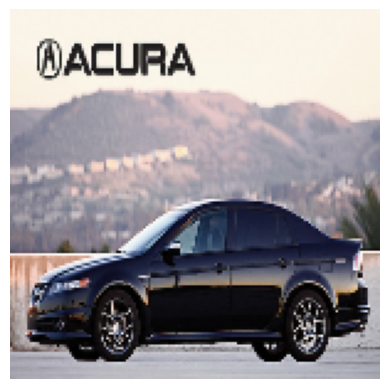

In [24]:
im = cv2.imread("/content/dataset/data1a/validation/01-whole/0006.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (150, 150))
imS=im.reshape([1,150,150,3])
pred=model.predict(np.array(imS))
print(pred)
if pred[0][0]<0.5:
    print("The car is damaged")
else:
    print("The car is not damaged")
plt.axis("off")
plt.imshow(im)


Conclusion: Successfully build a classifier to classify the images containing into damage and undamage cars.

# Inference - SURA data

In [25]:
# Clone the GitHub repo
!rm -rf car_damage_detector
repo_url = "https://github.com/slunara/car_damage_detector.git"
!git clone {repo_url}

test_data_dir = "car_damage_detector/test_data"

assert os.path.exists(test_data_dir), "Test data folder not found!"
print("Test data downloaded successfully!")

Cloning into 'car_damage_detector'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 292 (delta 16), reused 3 (delta 3), pack-reused 254 (from 3)
Receiving objects: 100% (292/292), 100.28 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (163/163), done.
Test data downloaded successfully!


In [26]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input


IMG_SIZE = (150, 150)

class_labels = {"damage": 0, "whole": 1}

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)  # Load and resize
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = preprocess_input(img_array)  # Normalize
    return img_array

# Function to load test images from both classes
def load_test_images(test_data_dir):
    test_images = []
    test_labels = []
    test_filenames = []

    for category in ["damage", "whole"]:  # Iterate over both classes
        folder_path = os.path.join(test_data_dir, category)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img_array = load_and_preprocess_image(img_path)
            test_images.append(img_array)
            test_labels.append(class_labels[category])
            test_filenames.append(img_name)

    return np.array(test_images), np.array(test_labels), test_filenames

X_test, y_test, filenames = load_test_images(test_data_dir)

print(f"Loaded {len(X_test)} test images!")

Loaded 152 test images!


In [27]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Evaluate the model
accuracy = np.mean(y_pred_labels.flatten() == y_test)
print(f"✅ Model Accuracy on Test Data: {accuracy * 100:.2f}%")



5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step
✅ Model Accuracy on Test Data: 57.89%


In [28]:
from sklearn.metrics import recall_score

# Calculate recall score
recall = recall_score(y_test.flatten(), y_pred_labels)

# Print recall score
print(f"✅ Model Recall on Test Data: {recall:.4f}")

✅ Model Recall on Test Data: 0.6131


## Confusion matrix

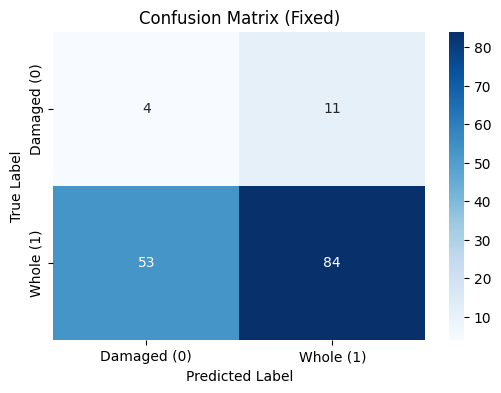

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


y_pred_labels = y_pred_labels.flatten()

cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Damaged (0)", "Whole (1)"],
            yticklabels=["Damaged (0)", "Whole (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fixed)")
plt.show()

## ROC curve

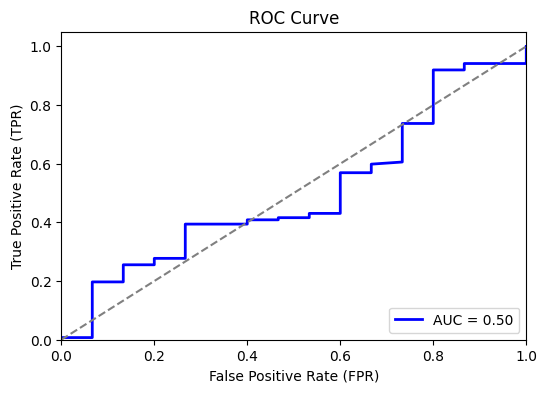

In [30]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # Use probabilities
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Optimal treshold

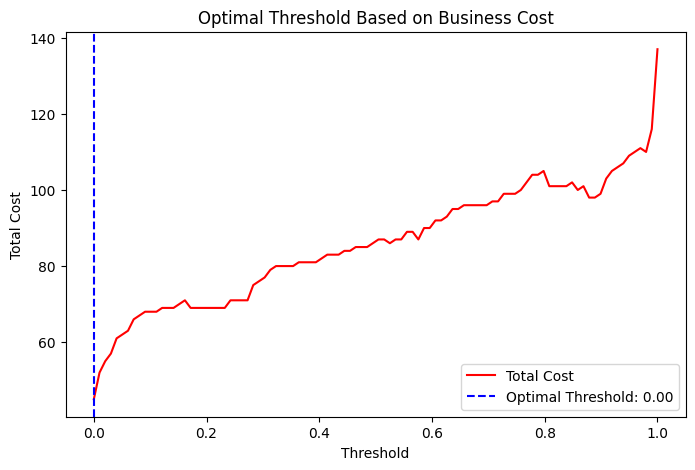

✅ Optimal Threshold for Cost Minimization: 0.00


In [31]:
def find_optimal_threshold(y_true, y_pred_probs, fp_cost=3, fn_cost=1):
    """
    Finds the optimal threshold for classification based on cost minimization.

    Parameters:
    - y_true: True labels (0 = Damaged, 1 = Whole)
    - y_pred_probs: Predicted probabilities
    - fp_cost: Cost of a False Positive (wrongly classified as damaged)
    - fn_cost: Cost of a False Negative (wrongly classified as whole)

    Returns:
    - optimal_threshold: The threshold that minimizes total cost
    """

    thresholds = np.linspace(0, 1, 100)  # Generate 100 thresholds from 0 to 1
    costs = []  # Store cost for each threshold

    for threshold in thresholds:
        y_pred_labels = (y_pred_probs >= threshold).astype(int)  # Convert probs to binary labels
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_labels).ravel()

        # Compute total cost
        total_cost = (fp * fp_cost) + (fn * fn_cost)
        costs.append(total_cost)

    # Find threshold with minimum cost
    optimal_index = np.argmin(costs)
    optimal_threshold = thresholds[optimal_index]

    # Plot Cost vs Threshold
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, costs, label="Total Cost", color="red")
    plt.axvline(x=optimal_threshold, color="blue", linestyle="--", label=f"Optimal Threshold: {optimal_threshold:.2f}")
    plt.xlabel("Threshold")
    plt.ylabel("Total Cost")
    plt.title("Optimal Threshold Based on Business Cost")
    plt.legend()
    plt.show()

    return optimal_threshold

# Find the optimal threshold
optimal_threshold = find_optimal_threshold(y_test, y_pred)
print(f"✅ Optimal Threshold for Cost Minimization: {optimal_threshold:.2f}")

## Verify visually the results

In [32]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Define image size
IMG_SIZE = (150, 150)

# Define class labels (damage = 0, whole = 1)
class_labels = {"damage": 0, "whole": 1}

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)  # Load and resize
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize
    return img_array

# Function to load test images from both classes
def load_test_images(test_data_dir):
    test_images = []
    test_labels = []
    test_filenames = []

    for category in ["damage", "whole"]:  # Iterate over both classes
        folder_path = os.path.join(test_data_dir, category)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img_array = load_and_preprocess_image(img_path)
            test_images.append(img_array)
            test_labels.append(class_labels[category])
            test_filenames.append(img_name)

    return np.vstack(test_images), np.array(test_labels), test_filenames

# Load test images
X_test, y_test, filenames = load_test_images(test_data_dir)

print(f"✅ Loaded {len(X_test)} test images!")

# Get predictions from the model
y_pred_probs = best_model.predict(X_test)  # Model outputs probabilities
y_pred_labels = (y_pred_probs > 0.5).astype(int)  # Convert to 0 (damage) or 1 (whole)


✅ Loaded 152 test images!
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


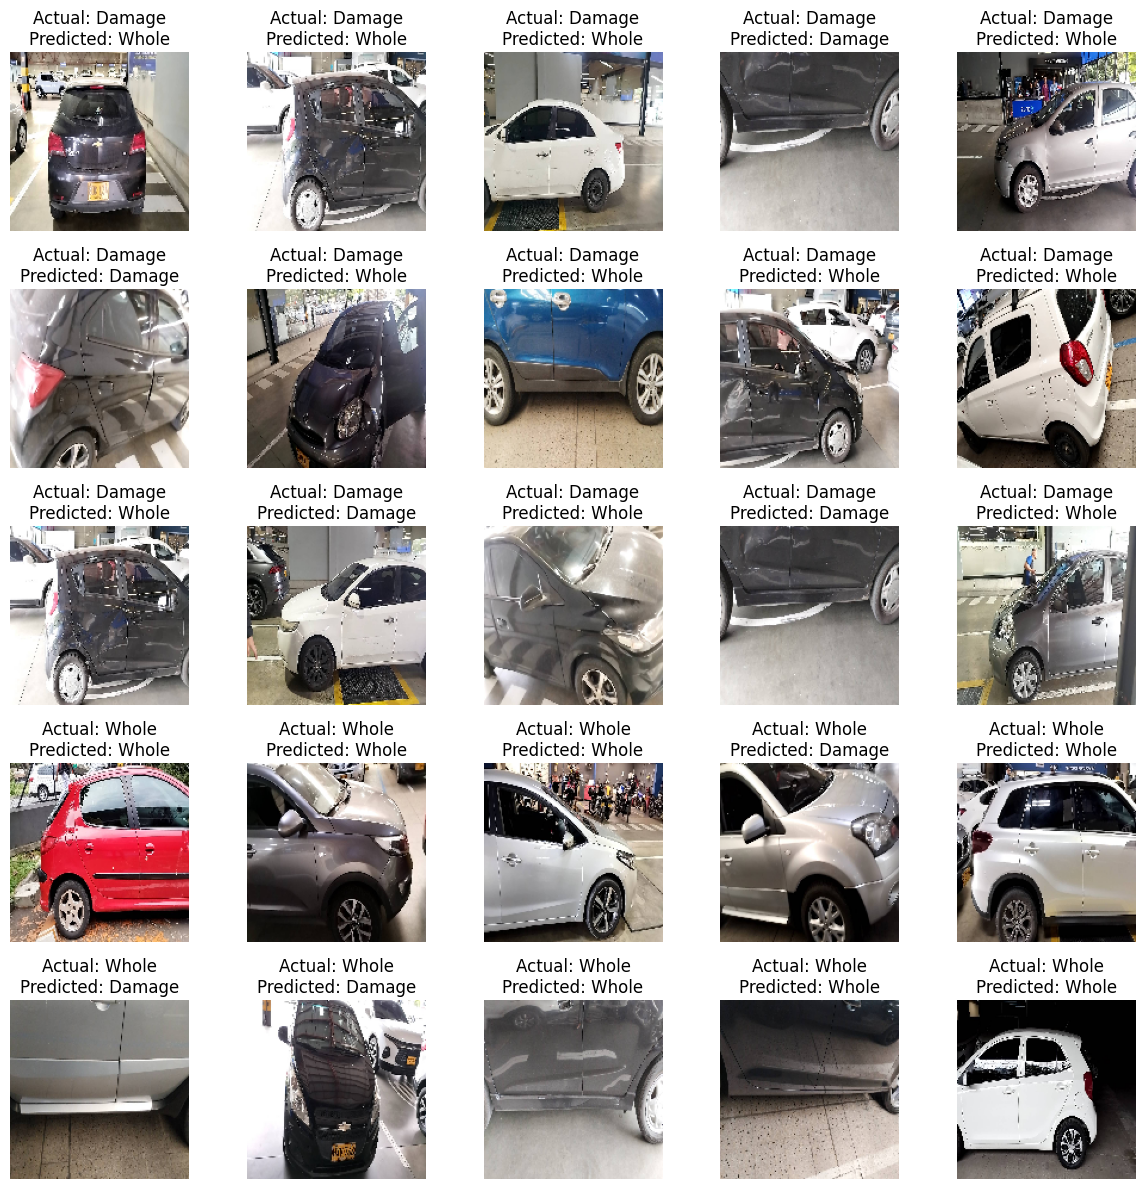

In [33]:

# Show sample predictions
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()

for i in range(25):
    # Ensure index is within bounds
    if i >= len(filenames):
        break

    # Load image again for visualization
    img_path = os.path.join(test_data_dir, "damage" if y_test[i] == 0 else "whole", filenames[i])
    img = load_img(img_path, target_size=IMG_SIZE)

    # Display image
    axes[i].imshow(img)
    axes[i].axis("off")

    # Show actual vs predicted labels
    actual_label = "Damage" if y_test[i] == 0 else "Whole"
    predicted_label = "Damage" if y_pred_labels[i] == 0 else "Whole"
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()
